# Introduction

In this notebook, we will generate handwritten digits using the Generative Adversarial Networks (GANs), as introduced in the [paper](https://arxiv.org/abs/1406.2661) by Goodfellow et al. The strength of GANs lies in producing photorealistic images (much clearer than previous generative modeling techniques). Since its introduction, GANs have become extremely popular in the deep learning community and the number of papers published per year on GANs is growing exponentially. A GAN works by simultaneously training two neural networks (generator and discriminator), trying to achieve equilibrium. The discriminator classifies an image into real or fake and the generator is trained in such a way that the images that it produces maximizes the probability of the discriminator classifying them as real. As this proceeds, the generator starts producing realistic images.  

# Preparing data

We will train our GAN on the MNIST dataset of handwritten digits. We will ignore the test data as we will generate new samples, and not classify them.

In [216]:
from keras.datasets import mnist

(x_train, y_train), (_, _) = mnist.load_data()
x_train = x_train.astype('float32').reshape(x_train.shape + (1,)) / 255.
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


# Building the generator model
The generator model will be a devonvolutional neural network. It will take a latent vector and deconvolve it into a 28x28 image. Using LeakyReLU instead of ReLU as the activation function for the convolutional layers has shown to increase the training performance as it reduces the sparseness in the gradients. Also, using tanh instead of sigmoid in the last convolution layer has empirically shown to improve training performance. We will save this generator as a separate model and feed it random vectors to generate samples once it gets trained.

In [217]:
from keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, LeakyReLU
from keras.models import Model
from keras import Input
from keras import backend as K
import numpy as np

K.clear_session()

# Hyperparameters
hidden_state_size = 100

input_gen = Input(shape=(hidden_state_size,))
x = Dense(64 * 14 * 14)(input_gen)
x = LeakyReLU()(x)
x = Reshape((14, 14, 64))(x)
x = Conv2D(128, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(128, 4, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(1, 7, activation='tanh', padding='same')(x)
gen = Model(input_gen, x)
gen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
__________

# Building the discriminator model
A discriminator is just a convolutional neural network. It takes an image as an input and finds the probability of it being real. We use Dropout to improve the robustness of the model. We will manually train the discriminator, as described in the next step, and disable the auto-training of its weights.

In [218]:
from keras.layers import Flatten, Dropout
from keras.optimizers import RMSprop

input_dis = Input(shape=(28, 28, 1))
x = Conv2D(64, 3)(input_dis)
x = LeakyReLU()(x)
x = Conv2D(128, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(256, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(256, 4, strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
dis = Model(input_dis, x)
dis.summary()
dis.compile(optimizer=RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8),
                      loss='binary_crossentropy')
dis.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       131200    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 256)         524544    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 5, 5, 256)         0         
__________

# Training GAN
### Creating the model
We will stack our generator and discriminator models into a single GAN model: We feed a latent vector, the generator generates an image and the discriminator tells the probability of it being real. 

In [0]:
input_gan = Input(shape=(hidden_state_size,))
gan = Model(input_gan, dis(gen(input_gan)))
gan.compile(optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8),
            loss='binary_crossentropy')

### Training
Training a GAN is very different from training other neural networks. There are two different neural networks that need to be trained in such a way that they reach an equilibrium. This needs to be manually controlled and hence we cannot use keras.models.Model.fit function to train our GAN. The training process proceeds as follows:

1.   Generate a batch of random latent vectors by sampling from a normal distribution
2.   Generate the corresponding images of those vectors using the generator model
3.   Fetch a batch of real images from the training data
4.   Combine the two sets of images into a single batch and create the corresponding vector of labels. Add some noise to this vector to improve robustness
5.   Train the discriminator model using this batch of images and labels
6.   Again generate a batch of random latent vectors by sampling from a normal distribution
7.   Create a corresponding vector of labels with all labels being real
8.   [KEY] Feed the latent vectors and the real labels to the GAN model. Since the discriminator's weights are fixed, this causes the generator to update its weights such that the discriminator predicts those images as real.

Repeating this gradually makes the discriminator better at classifying real/fake images and the generator gets better at fooling the discriminator. At the end of the training, the generator starts producing real-like images.

In [220]:
from time import time

iterations = 10000
batch_size = 30
cursor = 0

start_time = time()
for it in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, hidden_state_size))
    fake_images = gen.predict(random_latent_vectors)
    real_images = x_train[cursor: cursor + batch_size]
    mixed_images = np.concatenate([real_images, fake_images])
    true_labels = np.concatenate([np.zeros((batch_size, 1)),
                             np.ones((batch_size, 1))])
    true_labels += 0.05 * np.random.random(true_labels.shape)
    dis_loss = dis.train_on_batch(mixed_images, true_labels)
    random_latent_vectors = np.random.normal(size=(batch_size, hidden_state_size))
    fake_labels = np.zeros((batch_size, 1))
    gen_loss = gan.train_on_batch(random_latent_vectors, fake_labels)
    cursor += batch_size
    if cursor > len(x_train) - batch_size:
      cursor = 0
    if it % 100 == 0 and it > 0:
        end_time = time()
        time_per_100_it = end_time-start_time
        print("\tstep: {} | discriminator_loss: {:5.5f} | generator_loss: {:5.5f} | time_left: {} minutes".format(
                it, dis_loss, gen_loss, int((((iterations-it)/100)*time_per_100_it)/60)))
        start_time = end_time

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


	step: 100 | discriminator_loss: -0.12046 | generator_loss: 15.94238 | time_left: 36 minutes
	step: 200 | discriminator_loss: 0.03219 | generator_loss: 10.46863 | time_left: 28 minutes
	step: 300 | discriminator_loss: 0.24412 | generator_loss: 11.02792 | time_left: 28 minutes
	step: 400 | discriminator_loss: 0.33522 | generator_loss: 2.45347 | time_left: 28 minutes
	step: 500 | discriminator_loss: 0.23284 | generator_loss: 2.95015 | time_left: 28 minutes
	step: 600 | discriminator_loss: 0.30631 | generator_loss: 2.12142 | time_left: 27 minutes
	step: 700 | discriminator_loss: 0.28856 | generator_loss: 4.09703 | time_left: 27 minutes
	step: 800 | discriminator_loss: 1.13413 | generator_loss: 1.30300 | time_left: 27 minutes
	step: 900 | discriminator_loss: 0.06810 | generator_loss: 4.74987 | time_left: 27 minutes
	step: 1000 | discriminator_loss: 0.75853 | generator_loss: 3.64325 | time_left: 26 minutes
	step: 1100 | discriminator_loss: 0.00104 | generator_loss: 4.93477 | time_left: 26 m

# Visualization
We generate some random latent space vectors from a normal distribution, feed them to the trained generator model and display the output images using Matplotlib.

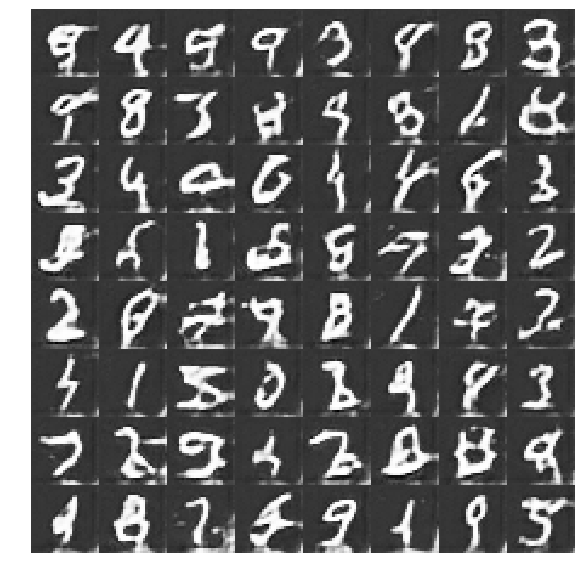

In [227]:
import matplotlib.pyplot as plt

grid_size = 8
digit_size = 28
samples_count = grid_size*grid_size
random_latent_vectors = np.random.normal(size=(samples_count, hidden_state_size))
generated_images = gen.predict(random_latent_vectors)
figure = np.zeros((grid_size*digit_size, grid_size*digit_size))

for i in range(grid_size*grid_size):
  row = int(i/grid_size)
  column = i%grid_size
  figure[row*digit_size:(row+1)*digit_size, 
         column*digit_size:(column+1)*digit_size] = generated_images[i].reshape(digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# References


*   [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
*   [Deep Learning book](https://www.deeplearningbook.org/)
* [Deep Learning with Python](https://www.oreilly.com/library/view/deep-learning-with/9781617294433/)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)
* [CS231n:  Generative Models (video)](https://www.youtube.com/watch?v=5WoItGTWV54&t=3934s)
* [NIPS 2016: Generative Adversarial Networks by Ian Goodfellow (video)](https://www.youtube.com/watch?v=AJVyzd0rqdc&t=4117s)
* [Generative Adversarial Networks Wiki](https://en.wikipedia.org/wiki/Generative_adversarial_network)
